# Use of regression methods to predict wine quality

In [1]:
%matplotlib notebook
import warnings
warnings.filterwarnings('ignore')

from termcolor import colored

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, confusion_matrix

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

In [2]:
data = pd.read_csv('winequality.csv', sep=';')

print('Loaded', len(data), 'samples')

Loaded 6497 samples


## Data cleaning

In [3]:
try:
    data['type'] = data['type'].map(lambda x: 1 if x == 'White' else 0)
    print('\' type \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' type ' field is fixed


In [4]:
def fix_alcohol_field(s):
    if s.count('.') > 1:
        return None
    else:
        return float(s)

In [5]:
try:
    data['alcohol'] = data['alcohol'].map(fix_alcohol_field)
    print('\' alcohol \' field is fixed')
except Exception as e:
    print('ERROR:', e)
    pass

' alcohol ' field is fixed


In [6]:
data = data.dropna() # samples with NULL values are removed

In [7]:
keys_list = list(data.keys())
def check_dirty(func, s):
    check = False
    for k in keys_list:
        counter = data[k].map(func).sum()
        if counter > 0:
            check = True
            print('\'',k, '\' field has', counter, s, 'values')
    if not check:
        print('There are no', s, 'values')

In [8]:
check_dirty(lambda x: type(x) is str, 'STRING')
check_dirty(lambda x: x is None, 'NONE')
print(data['alcohol'].isnull().sum(), 'NULL values in \' alcohol \' field')

There are no STRING values
There are no NONE values
0 NULL values in ' alcohol ' field


In [9]:
keys_output = ['quality'] # output fields
keys_input = list(set(keys_list) - set(keys_output)) # input fields

In [10]:
train_x, test_x, train_y, test_y = train_test_split(data[keys_input].as_matrix(),
                                                    data[keys_output].as_matrix(),
                                                    test_size=.10) # split 10% of data for testing

In [11]:
# building a normalized dataset to compare with models built on raw data

train_x_norm = np.zeros_like(train_x)
test_x_norm = np.zeros_like(test_x)
train_y_norm = train_y.copy()
test_y_norm = test_y.copy()
for k in range(len(keys_input)):
    mean = train_x[:,k].mean()
    var = train_x[:,k].var()
    train_x_norm[:,k] = (train_x[:,k] - mean)/var
    test_x_norm[:,k] = (test_x[:,k] - mean)/var

In [12]:
def hist_error(conf_matrix):
    r, c = conf_matrix.shape[:2]
    hist = [0]*np.max([r,c])
    for i in range(r):
        for j in range(c):
            hist[np.abs(i-j)] += conf_matrix[i,j]
    
    return hist

## Application of Linear Regression

In [13]:
model = LinearRegression()
regressor = GridSearchCV(model, {})
print('Training model with', len(train_x), 'samples')
regressor.fit(train_x, train_y)

Training model with 5811 samples


GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [14]:
prediction = np.round(regressor.predict(test_x))
print('Mean absolute error =', mean_absolute_error(prediction, test_y))

Mean absolute error = 0.5402476780185759


<IPython.core.display.Javascript object>


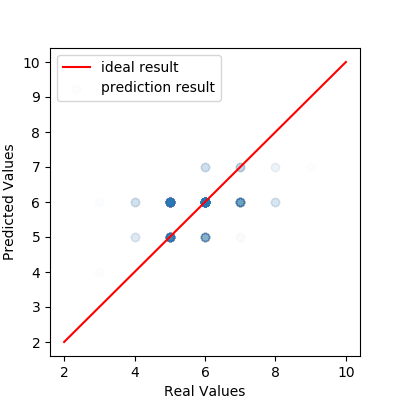

In [15]:
plt.figure(figsize=(4,4), num='Linear Regression - Raw Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [16]:
confusion_matrix(prediction, test_y)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0],
       [  0,  11, 103,  52,   2,   0,   0],
       [  1,  15, 132, 206,  66,  13,   0],
       [  0,   0,   0,  16,  21,   6,   1],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


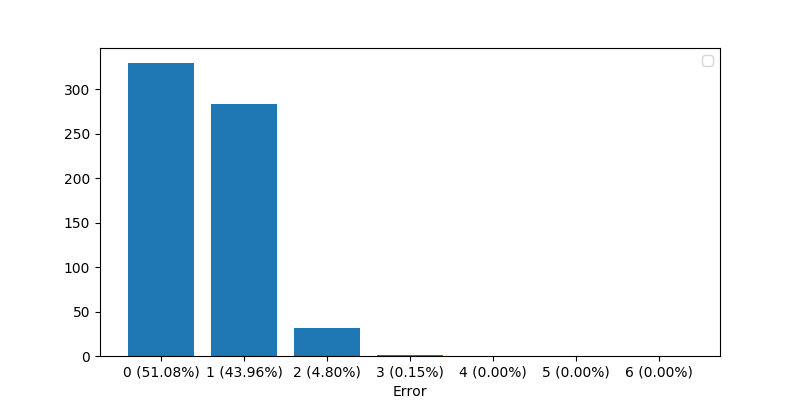

No handles with labels found to put in legend.


In [17]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='Linear Regression - Histogram of error')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();

### Using normalization ~ N(0,1)

In [18]:
model = LinearRegression()
regressor = GridSearchCV(model, {})

regressor.fit(train_x_norm, train_y_norm)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
prediction = np.round(regressor.predict(test_x_norm))
print('Mean absolute error =', mean_absolute_error(prediction, test_y_norm))

Mean absolute error = 0.5402476780185759


<IPython.core.display.Javascript object>


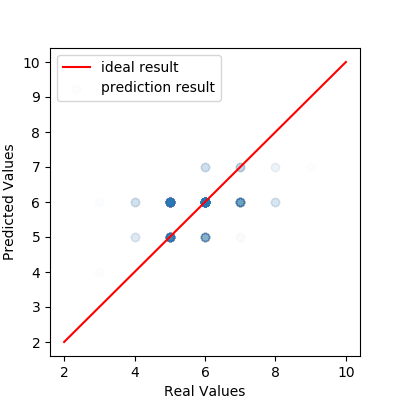

In [20]:
plt.figure(figsize=(4,4), num='Linear Regression - Normalized Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y_norm, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [21]:
confusion_matrix(prediction, test_y_norm)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0],
       [  0,  11, 103,  52,   2,   0,   0],
       [  1,  15, 132, 206,  66,  13,   0],
       [  0,   0,   0,  16,  21,   6,   1],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


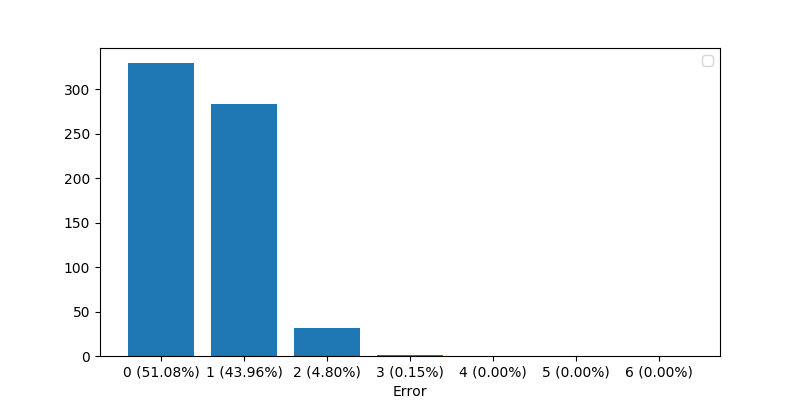

No handles with labels found to put in legend.


In [22]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='Linear Regression - Histogram of error with normalized data')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();

## Application of Regression based on SVM

In [23]:
model = SVR()
regressor = GridSearchCV(model, {'C':[1, 10, 100, 1000]}, verbose=1)

regressor.fit(train_x, train_y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   38.9s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [24]:
prediction = np.round(regressor.predict(test_x))
print('Mean absolute error =', mean_absolute_error(prediction, test_y))

Mean absolute error = 0.4969040247678019


<IPython.core.display.Javascript object>


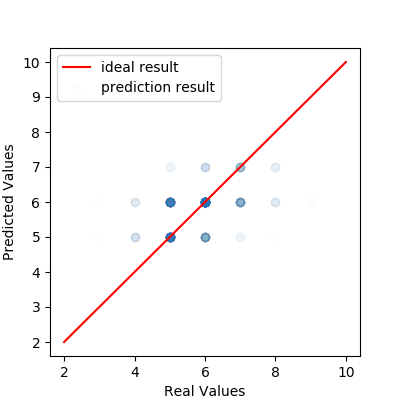

In [25]:
plt.figure(figsize=(4,4), num='SVM Regression - Raw Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [26]:
confusion_matrix(prediction, test_y)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0],
       [  1,  15, 122,  52,   5,   1,   0],
       [  1,  10, 108, 206,  51,  10,   1],
       [  0,   0,   5,  16,  33,   8,   0],
       [  0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


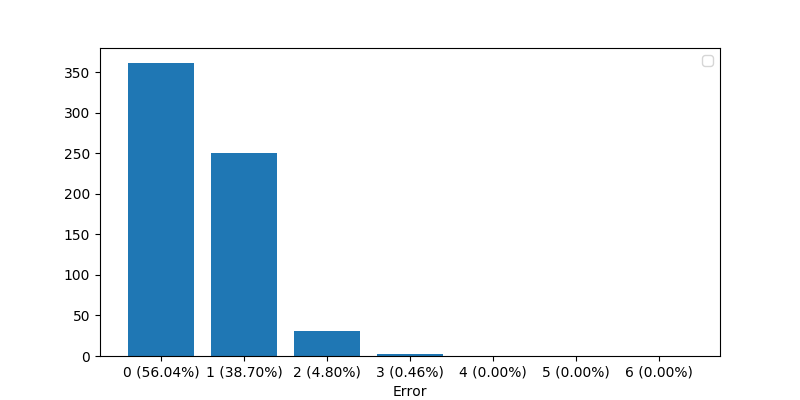

No handles with labels found to put in legend.


In [27]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='SVM Regression - Histogram of error')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();

### Using normalization ~ N(0,1)

In [28]:
model = SVR()
regressor = GridSearchCV(model, {'C':[1, 10, 100, 1000]}, verbose=1)

regressor.fit(train_x_norm, train_y_norm)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:   27.0s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [1, 10, 100, 1000]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring=None, verbose=1)

In [29]:
prediction = np.round(regressor.predict(test_x_norm))
print('Mean absolute error =', mean_absolute_error(prediction, test_y_norm))

Mean absolute error = 0.46904024767801855


<IPython.core.display.Javascript object>


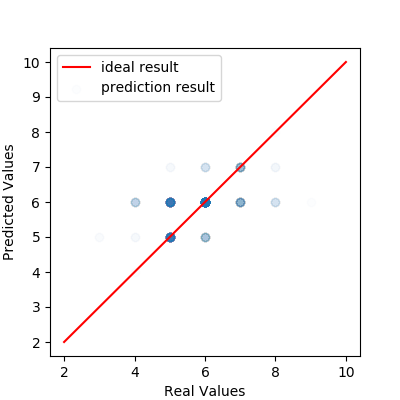

In [30]:
plt.figure(figsize=(4,4), num='SVM Regression - Normalized Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y_norm, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [31]:
confusion_matrix(prediction, test_y_norm)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0],
       [  2,   3, 117,  34,   0,   0,   0],
       [  0,  22, 115, 226,  48,  14,   1],
       [  0,   0,   3,  14,  41,   4,   0],
       [  0,   0,   0,   0,   0,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


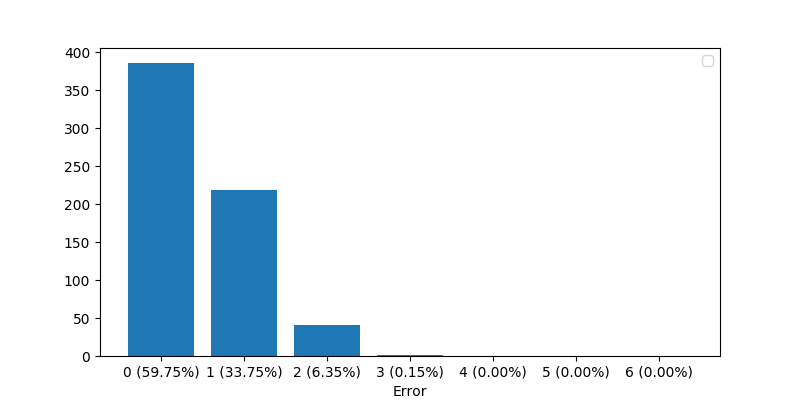

No handles with labels found to put in legend.


In [32]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='SVM Regression - Histogram of error with normalized data')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();

## Application of Regression based on KNN algorithm

In [33]:
model = KNeighborsRegressor(n_neighbors=4)

model.fit(train_x, train_y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

In [34]:
prediction = np.round(model.predict(test_x))
print('Mean absolute error =', mean_absolute_error(prediction, test_y))

Mean absolute error = 0.5975232198142415


<IPython.core.display.Javascript object>


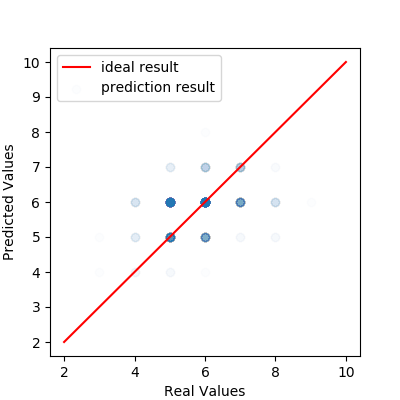

In [35]:
plt.figure(figsize=(4,4), num='KNN Regression - Raw Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [36]:
confusion_matrix(prediction, test_y)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  1,   4,   3,   1,   0,   0,   0],
       [  1,   9,  85,  56,   3,   3,   0],
       [  0,  13, 139, 193,  59,  14,   1],
       [  0,   0,   8,  23,  27,   2,   0],
       [  0,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


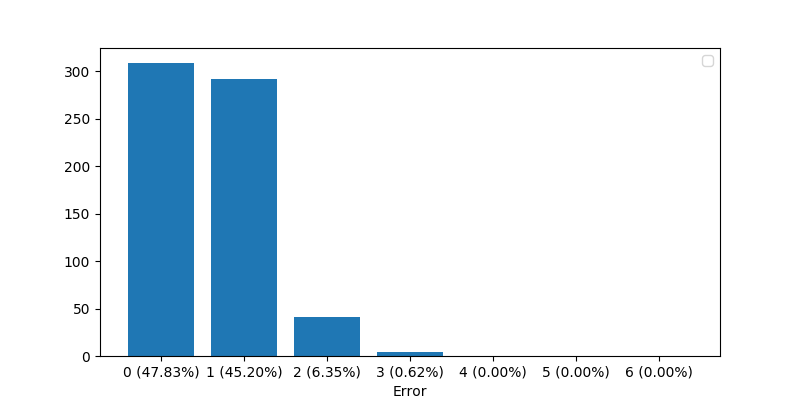

No handles with labels found to put in legend.


In [37]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='KNN Regression - Histogram of error')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();

### Using normalization ~ N(0,1)

In [38]:
model = KNeighborsRegressor(n_neighbors=4)

model.fit(train_x_norm, train_y_norm)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=4, p=2,
          weights='uniform')

In [39]:
prediction = np.round(model.predict(test_x_norm))
print('Mean absolute error =', mean_absolute_error(prediction, test_y_norm))

Mean absolute error = 0.5340557275541795


<IPython.core.display.Javascript object>


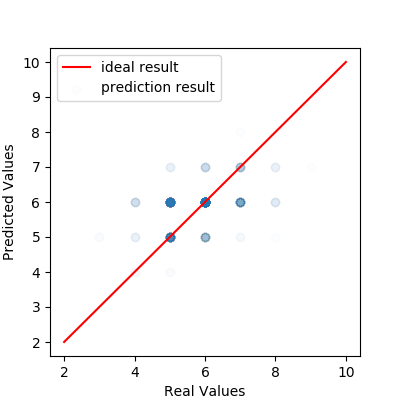

In [40]:
plt.figure(figsize=(4,4), num='KNN Regression - Normalized Data')
plt.xlabel('Real Values')
plt.ylabel('Predicted Values')
plt.plot([2, 10], [2, 10], 'r', label='ideal result')
plt.scatter(test_y_norm, prediction, label='prediction result', alpha=0.01);
plt.legend();

In [41]:
confusion_matrix(prediction, test_y_norm)

array([[  0,   0,   0,   0,   0,   0,   0],
       [  0,   3,   2,   0,   0,   0,   0],
       [  2,   7,  95,  40,   3,   1,   0],
       [  0,  16, 131, 216,  58,  10,   0],
       [  0,   0,   7,  18,  27,   7,   1],
       [  0,   0,   0,   0,   1,   1,   0],
       [  0,   0,   0,   0,   0,   0,   0]])

<IPython.core.display.Javascript object>


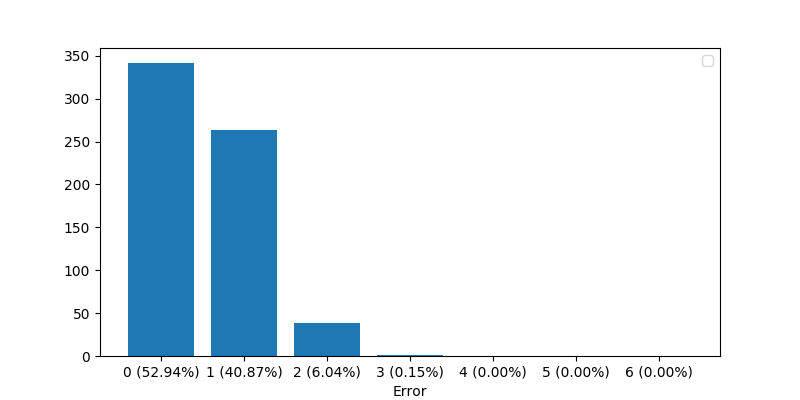

No handles with labels found to put in legend.


In [42]:
hist = hist_error(confusion_matrix(prediction, test_y))

plt.figure(figsize=(8,4), num='KNN Regression - Histogram of error with normalized data')
plt.xlabel('Error')
plt.bar(range(len(np.unique(test_y))), hist);
plt.xticks(range(len(np.unique(test_y))), [str(p)+' ({:.2f}%)'.format(100*i/np.sum(hist)) for p,i in enumerate(hist)])
plt.legend();